# Big Data Churn Prediction with Spark

+ This project involves developing a machine learning classification model to predict customer churn, evaluating the model's performance, and visualizing the results. By doing so, we aim to gain valuable insights to support business decisions.

+ To predict customer behavior, we will use one of the PySpark machine learning packages called **_GBTClassifier_**.

<img src= 'https://www.cleartouch.in/wp-content/uploads/2022/11/Customer-Churn.png'>

### Importing the necessary packages

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

### Importing the data

In [2]:
df = pd.read_csv('churn.csv')

### EDA - Exploratory Data Analysis

In [3]:
df.head()

,Unnamed: 0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,0,Cameron Williams,42.0,11066.80,0,7.22,8.0,1
1,1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,1
2,2,Eric Lozano,38.0,12884.75,0,6.67,12.0,1
3,3,Phillip White,42.0,8010.76,0,6.71,10.0,1
4,4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       900 non-null    int64  
 1   Names            900 non-null    object 
 2   Age              900 non-null    float64
 3   Total_Purchase   900 non-null    float64
 4   Account_Manager  900 non-null    int64  
 5   Years            900 non-null    float64
 6   Num_Sites        900 non-null    float64
 7   Churn            900 non-null    int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 56.4+ KB


In [5]:
df.tail()

,Unnamed: 0,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
895,895,Paul Miller,42.0,12800.82,1,3.62,8.0,0
896,896,Natalie Hodges,52.0,9893.92,0,6.91,7.0,0
897,897,Ana Smith,45.0,12056.18,0,5.46,4.0,0
898,898,Justin Leonard,51.0,6517.93,1,5.47,10.0,0
899,899,Joseph Williams,39.0,9315.60,1,5.02,10.0,0


In [6]:
df.isnull().sum()

Unnamed: 0         0
Names              0
Age                0
Total_Purchase     0
Account_Manager    0
Years              0
Num_Sites          0
Churn              0
dtype: int64

### Feature Engineering

In [7]:
df.drop(['Unnamed: 0','Names'], axis=1,inplace=True)

In [8]:
df.head()

,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Churn
0,42.0,11066.80,0,7.22,8.0,1
1,41.0,11916.22,0,6.50,11.0,1
2,38.0,12884.75,0,6.67,12.0,1
3,42.0,8010.76,0,6.71,10.0,1
4,37.0,9191.58,0,5.56,9.0,1


### Initializing the Spark Session

In [9]:
spark = SparkSession.builder \
    .appName('Churn Prediction') \
    .getOrCreate()
data = spark.createDataFrame(df)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/17 21:03:01 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [10]:
data.printSchema() #showing the data schema

root
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: long (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: long (nullable = true)



In [11]:
feature_columns = ['Age', 'Total_Purchase', 'Account_Manager', 'Years','Num_Sites']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
data = assembler.transform(data)

final_data = data.select('features', 'churn') #selecting only the features and label
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42) #splitting the data into training and test sets
gbt = GBTClassifier(labelCol='churn', featuresCol='features', maxIter=10) #initializing the GBTClassifier

In [12]:
#fit and predict
model = gbt.fit(train_data)
predictions = model.transform(test_data)

In [13]:
#evaluating the model
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='accuracy')
accuracy = accuracy_evaluator.evaluate(predictions)

#precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='weightedPrecision')
precision = precision_evaluator.evaluate(predictions)

#recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='weightedRecall')
recall = recall_evaluator.evaluate(predictions)

#F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol='churn', predictionCol='prediction', metricName='f1')
f1_score = f1_evaluator.evaluate(predictions)

print(f"Test set accuracy: {accuracy:.2f}")
print(f"Test set weighted precision: {precision:.2f}")
print(f"Test set weighted recall: {recall:.2f}")
print(f"Test set F1 score: {f1_score:.2f}")

25/02/17 21:03:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


Test set accuracy: 0.87
Test set weighted precision: 0.86
Test set weighted recall: 0.87
Test set F1 score: 0.86


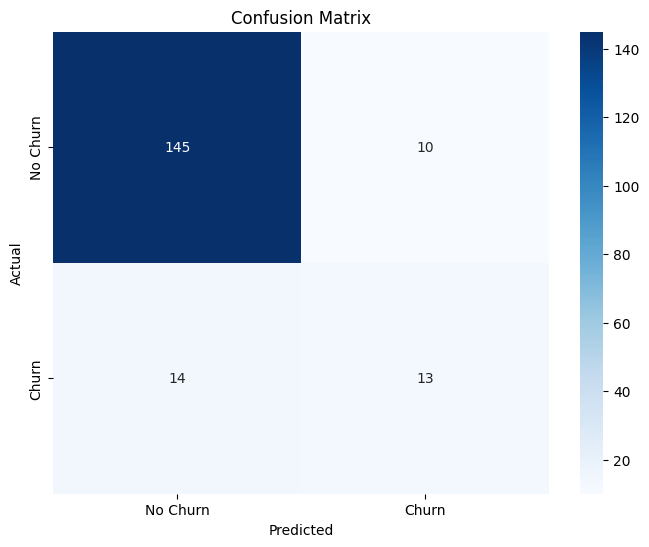

In [14]:
#confusion matrix
y_true = predictions.select('churn').toPandas()
y_pred = predictions.select('prediction').toPandas()

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

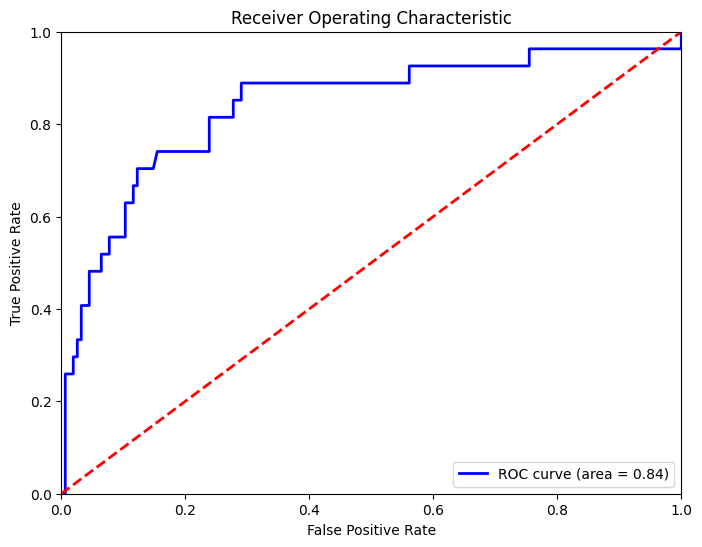

In [15]:
#ROC curve
y_scores = model.transform(test_data).select('probability').toPandas()
y_scores = [p[1] for p in y_scores['probability']]

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

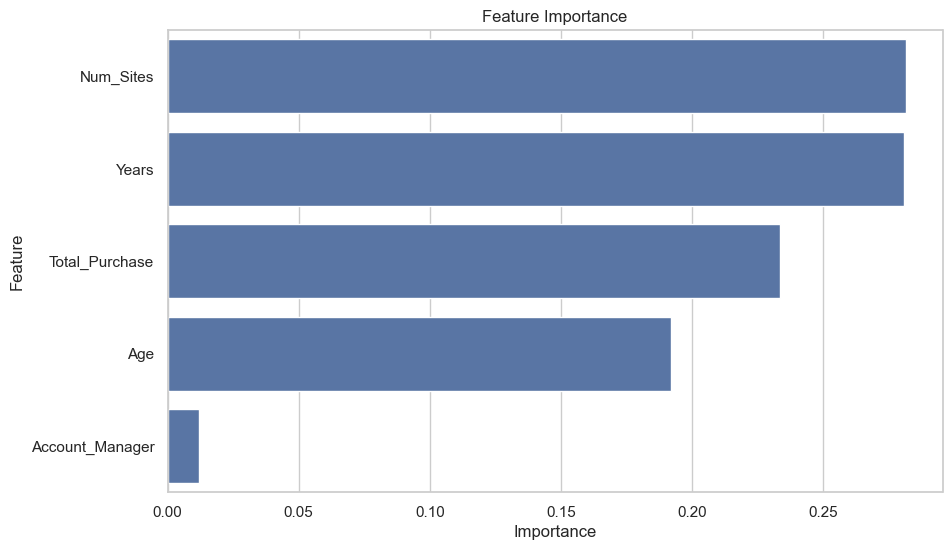

In [17]:
#feature importances graph
importances = model.featureImportances.toArray()
features = feature_columns

feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.sort_values('Importance', ascending=False))
plt.title('Feature Importance')
plt.show()

In [18]:
spark.stop() #stopping the Spark session

## Results and Evaluation

+ With its big data processing capabilities, Spark has enabled us to achieve significant results with the developed model, demonstrating its effectiveness in predicting customer churn. The high accuracy and F1 score indicate that the model classifies both positive and negative examples effectively.

+ Using the results obtained from the data with the model developed in this project, marketing strategies can be enhanced. Special campaigns can be created for customers at high risk of churn. This way, customer churn can be reduced, and customer loyalty can be increased.